## *Re-do* of Initial test runs - basic simulations, sparse fields where PSFs are known perfectly.

Here we add random 0.05-pixel offsets.

Original runs were in `26. algorithm shootout - detection-Copy3.ipynb`. These are re-run with more static sources, more variable sources, and accurate ~5-sigma transients.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 16
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

#import time
#time.sleep(600)

3


In [2]:
import diffimTests as dit
reload(dit)

sky = 300.
n_sources = 1000
n_varSources = 50
varSourceFlux = 750.
scintillation = 0.05

global_psf1 = [1.6,1.6]   # old parameters
global_psf2 = [1.8,2.2]

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=global_psf1, psf2=global_psf2,
                         offset=[0,0], psf_yvary_factor=0., sourceFluxDistrib='exponential',
                         varFlux2=np.repeat(varSourceFlux, n_varSources), variablesNearCenter=False,
                         theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                         sourceFluxRange=(400,100000), scintillation=scintillation,
                         seed=66, psfSize=21, avoidBorder=True)

print dit.computeClippedImageStats(testObj.im1.im)
print dit.computeClippedImageStats(testObj.im2.im)
print dit.computeClippedImageStats(testObj.im1.var)
print dit.computeClippedImageStats(testObj.im2.var)
print testObj.astrometricOffsets

diffimTests.py:265: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  (offset2[0]-starSize+1):(offset2[0]+starSize)] += tmp1
diffimTests.py:290: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  (offset2[0]-starSize+1):(offset2[0]+starSize)] += tmp


(2.1422583269358615, 18.157805726749007, -76.999986925214671, 3398.4233101943014)
(2.681621552307933, 18.34755485004294, -75.0, 2259.2135867128286)
(302.1422583269358, 18.157805726749007, 223.00001307478533, 3698.4233101943014)
(302.68162155230783, 18.347554850042936, 225.0, 2559.2135867128286)
[0.0029439383961109462, 0.0027142477142506438]


In [3]:
det = testObj.runTest()
print det

{'ZOGY': {'FP': 3, 'FN': 39, 'TP': 11}, 'ALstack': {'FP': 8, 'FN': 42, 'TP': 8}, 'SZOGY': {'FP': 2, 'FN': 39, 'TP': 11}, 'ALstack_noDecorr': {'FP': 6, 'FN': 39, 'TP': 11}}


Try some real tests!

In [18]:
# Default 10 sources with same flux
def runTest(flux, seed=66, sky=300., n_sources=1000, n_varSources=50, scintillation=0., returnObj=False):
    #methods = ['ALstack', 'ZOGY', 'ZOGY_S', 'ALstack_noDecorr']
    testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=global_psf1, psf2=global_psf2,
                             offset=[0,0], psf_yvary_factor=0., sourceFluxDistrib='exponential',
                             varFlux2=np.repeat(flux, n_varSources), variablesNearCenter=False,
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(400,100000), scintillation=scintillation,
                             seed=seed, psfSize=21, avoidBorder=True)
    det = testObj.runTest() #subtractMethods=methods) #, 'AL'])
    det['flux'] = flux
    det['scint'] = scintillation
    if returnObj:
        det['testObj'] = testObj
    return det

methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']

## Look at detection rates for 5.0-sigma sources.

In [5]:
inputs = [(f, seed) for f in [750.] for seed in np.arange(66, 166, 1)]
print len(inputs)
testResults1 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], scintillation=0.05) for i in inputs)

100


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  6.9min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed: 19.3min finished


FN: 
ALstack             36.73
ALstack_noDecorr    34.87
SZOGY               36.80
ZOGY                33.98
dtype: float64
FP: 
ALstack             6.07
ALstack_noDecorr    6.65
SZOGY               5.81
ZOGY                6.52
dtype: float64
TP: 
ALstack             13.21
ALstack_noDecorr    15.05
SZOGY               13.13
ZOGY                15.95
dtype: float64


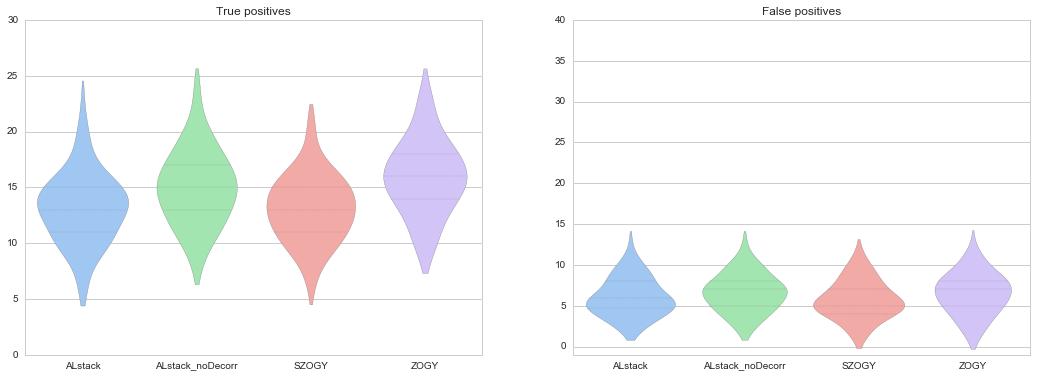

In [6]:
def plotResults(tr):
    FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
    FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})
    TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
    print 'FN:', '\n', FN.mean()
    print 'FP:', '\n', FP.mean()
    print 'TP:', '\n', TP.mean()

    matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
    fig, axes = plt.subplots(nrows=1, ncols=2)

    sns.violinplot(data=TP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[0])
    axes[0].set_title('True positives')
    #axes[0].set_ylim((0, 31))
    sns.violinplot(data=FP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[1])
    axes[1].set_title('False positives')
    axes[1].set_ylim((-1, 40))
    
plotResults(testResults1)

### OK, clearly scintillation of ~0.05 pixels does not degrade A&L. What level of scintillation does?

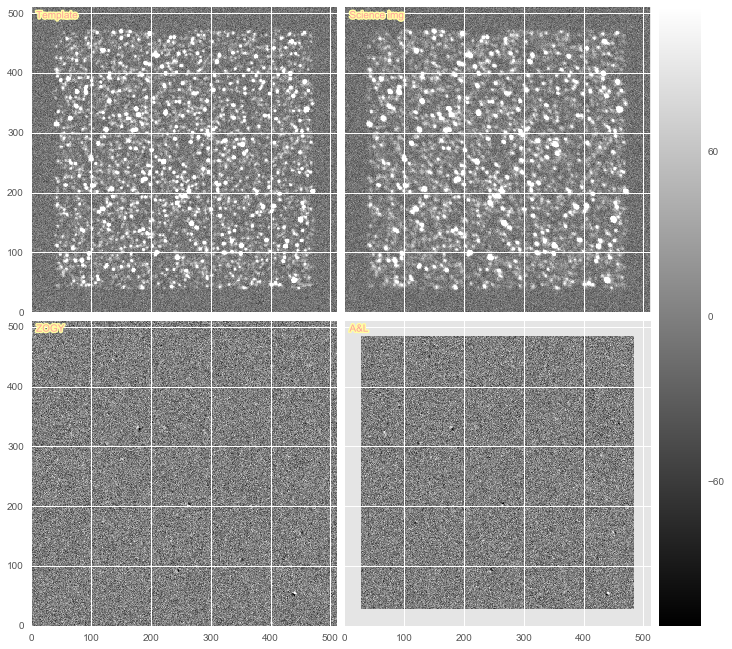

In [7]:
res = runTest(750, seed=66, sky=300., n_sources=5000, n_varSources=50, returnObj=True)
fig = plt.figure(1, (12, 12))
res['testObj'].doPlot()

In [8]:
inputs = [(f, seed) for f in [750.] for seed in np.arange(66, 166, 1)]
print len(inputs)
testResults2 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], scintillation=0.1) for i in inputs)

100


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  7.1min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed: 19.4min finished


FN: 
ALstack             37.37
ALstack_noDecorr    35.57
SZOGY               37.04
ZOGY                34.82
dtype: float64
FP: 
ALstack             10.01
ALstack_noDecorr    11.03
SZOGY                5.83
ZOGY                11.65
dtype: float64
TP: 
ALstack             12.57
ALstack_noDecorr    14.35
SZOGY               12.89
ZOGY                15.11
dtype: float64


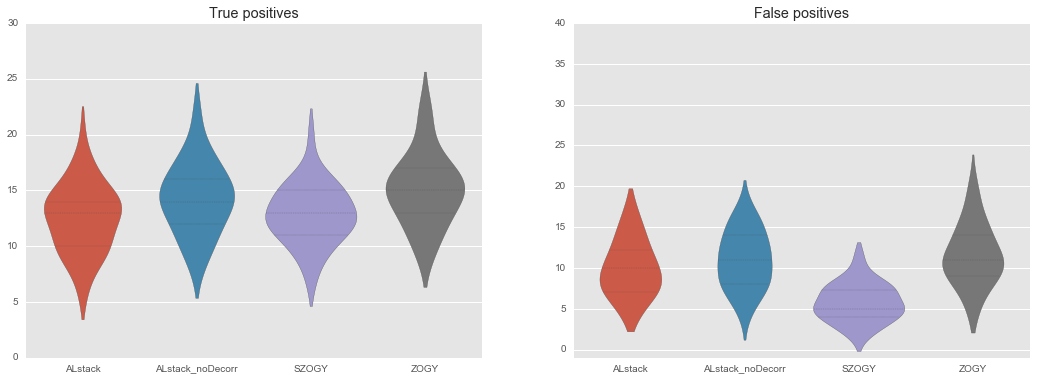

In [9]:
plotResults(testResults2)

In [11]:
inputs = [(f, seed) for f in [750.] for seed in np.arange(66, 166, 1)]
print len(inputs)
testResults2 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], scintillation=0.25) for i in inputs)

100


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  6.8min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed: 14.6min finished


FN: 
ALstack             39.92
ALstack_noDecorr    38.13
SZOGY               38.06
ZOGY                37.08
dtype: float64
FP: 
ALstack             27.45
ALstack_noDecorr    30.37
SZOGY                6.13
ZOGY                30.41
dtype: float64
TP: 
ALstack             10.02
ALstack_noDecorr    11.80
SZOGY               11.88
ZOGY                12.85
dtype: float64


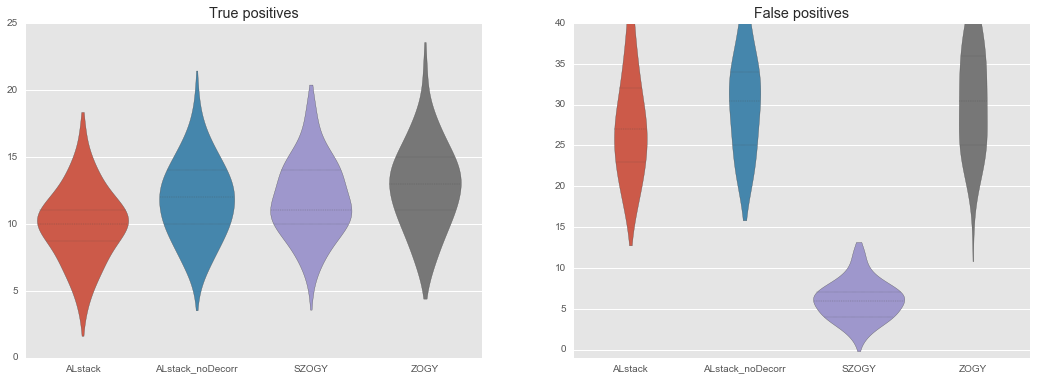

In [12]:
plotResults(testResults2)

In [13]:
import cPickle
import gzip
cPickle.dump((testResults1, testResults2), gzip.GzipFile('testResults3_NEW.p.gz', 'wb'))

In [20]:
inputs = [(f, seed, scint) for f in [750.] for seed in np.arange(66, 166, 1) for scint in [0., 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]]
print len(inputs)
testResults3 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], scintillation=i[2]) for i in inputs)

900


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 10.9min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 25.0min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 43.7min
[Parallel(n_jobs=4)]: Done 900 out of 900 | elapsed: 60.4min finished


In [21]:
import cPickle
import gzip
cPickle.dump((testResults1, testResults2, testResults3), gzip.GzipFile('testResults3_NEW.p.gz', 'wb'))

{'scint': 0.0, 'SZOGY': {'FP': 2, 'TP': 11, 'FN': 39}, 'ALstack_noDecorr': {'FP': 4, 'TP': 11, 'FN': 39}, 'ZOGY': {'FP': 5, 'TP': 12, 'FN': 38}, 'ALstack': {'FP': 5, 'TP': 9, 'FN': 41}, 'flux': 750.0}
FN: 
ALstack             39.363333
ALstack_noDecorr    37.640000
SZOGY               37.985556
ZOGY                36.716667
dtype: float64
FP: 
ALstack             24.204444
ALstack_noDecorr    26.941111
SZOGY                6.121111
ZOGY                26.892222
dtype: float64
TP: 
ALstack             10.576667
ALstack_noDecorr    12.284444
SZOGY               11.951111
ZOGY                13.217778
dtype: float64


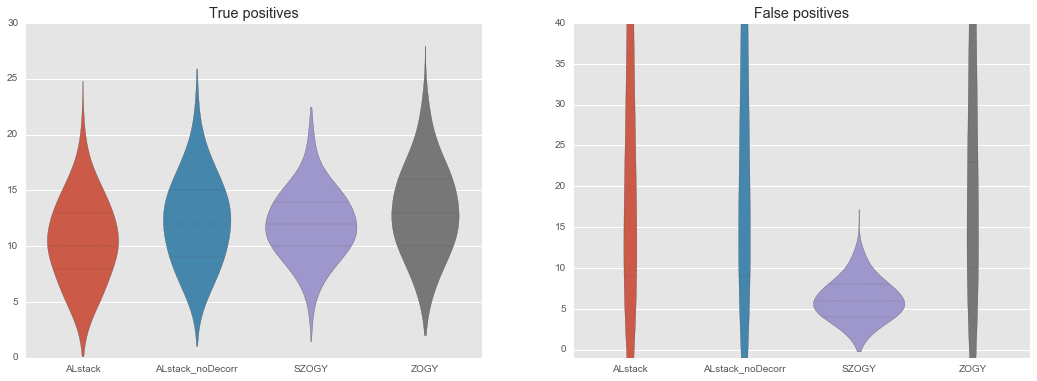

In [22]:
print testResults3[0]
plotResults(testResults3)

In [35]:
def plotResults(tr, methods=['ALstack', 'SZOGY']):
    tr = [t for t in tr if t is not None]
    tr = [t for t in tr if t is not None and t['scint']]
    TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
    FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
    FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})

    TP['scint'] = np.array([t['scint'] for t in tr])
    FP['scint'] = np.array([t['scint'] for t in tr])
    FN['scint'] = np.array([t['scint'] for t in tr])

    matplotlib.rcParams['figure.figsize'] = (24.0, 6.0)
    fig, axes = plt.subplots(nrows=1, ncols=2)

    tmp1 = TP[['scint', methods[0]]]
    tmp2 = TP[['scint', methods[1]]]
    tmp1['method'] = np.repeat(methods[0], tmp1.shape[0])
    tmp2['method'] = np.repeat(methods[1], tmp2.shape[0])
    tmp1.columns.values[1] = tmp2.columns.values[1] = 'TP'
    tmp = pd.concat((tmp1, tmp2))

    g = sns.violinplot(x='scint', y='TP', data=tmp, split=True, hue='method', inner="box", cut=0, 
                   linewidth=0.3, bw=0.5, ax=axes[0], scale='width')
    g.set_title('True Positives')
    g.set_ylim((0, 25))
    g.set_xlabel('Astrometric offset (pix.)')
    g.set_xticklabels(g.get_xticklabels(), rotation=30);

    tmp1 = FP[['scint', methods[0]]]
    tmp2 = FP[['scint', methods[1]]]
    tmp1['method'] = np.repeat(methods[0], tmp1.shape[0])
    tmp2['method'] = np.repeat(methods[1], tmp2.shape[0])
    tmp1.columns.values[1] = tmp2.columns.values[1] = 'FP'
    tmp = pd.concat((tmp1, tmp2))

    g = sns.violinplot(x='scint', y='FP', data=tmp, split=True, hue='method', inner="box", cut=0, 
                   linewidth=0.3, bw=0.5, ax=axes[1], scale='width')
    g.set_title('False Positives')
    g.set_ylim((0, 75))
    g.set_xlabel('Astrometric offset (pix.)')
    g.set_xticklabels(g.get_xticklabels(), rotation=30);
    
methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']

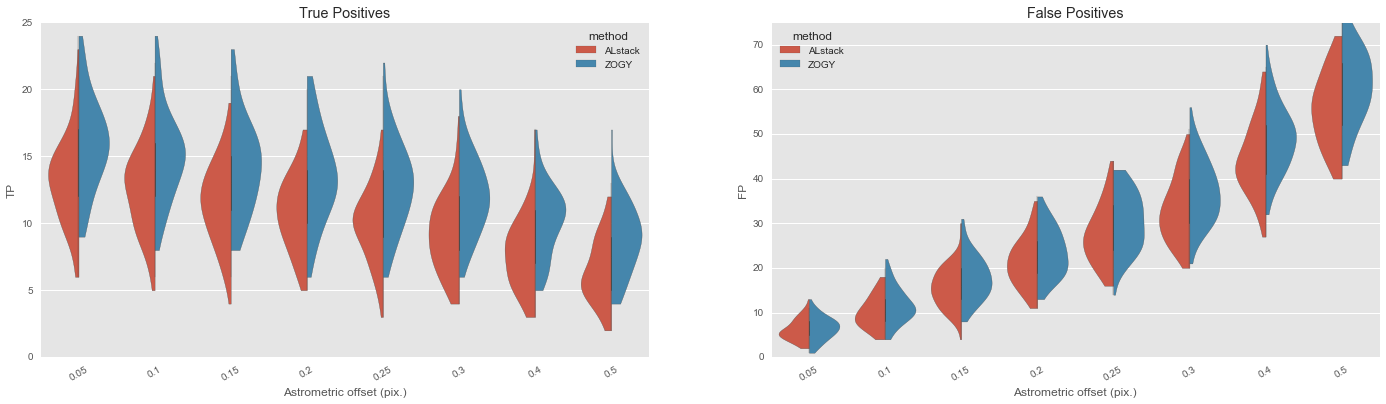

In [36]:
plotResults(testResults3, methods=['ALstack', 'ZOGY'])

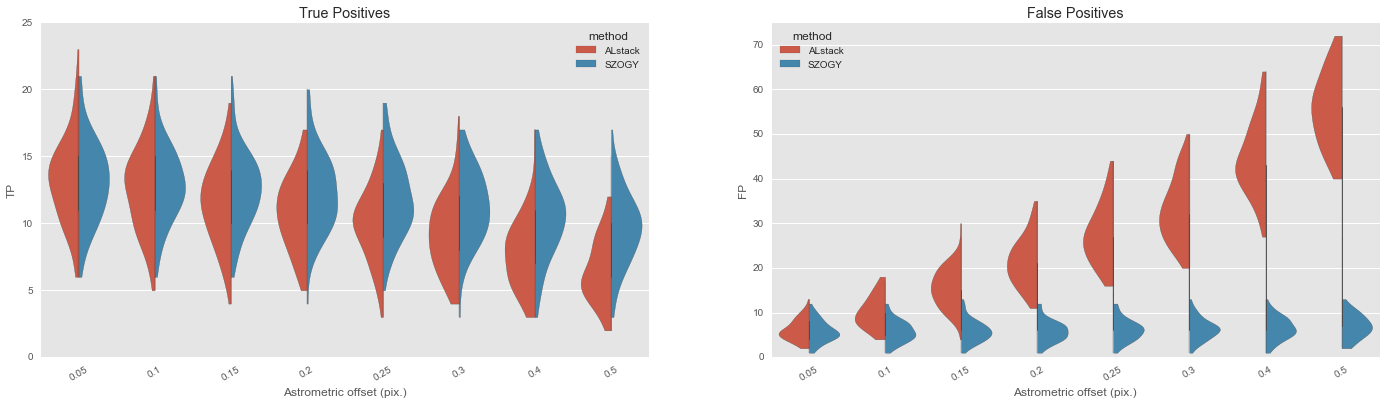

In [37]:
plotResults(testResults3, methods=['ALstack', 'SZOGY'])